In [9]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import json

# Load Data Pada CSV dan Proses menjadi Data Time Series

In [10]:
#Load data csv dan format data tahun bulan menjadi data frame
df = pd.read_csv('DATASET_PAJAK_MBLB.csv')
df['tahun'] = pd.to_datetime(df['tahun_bulan'])
df.head()

,tahun_bulan,jml_setor,tahun
0,2012-1,183057000,2012-01-01
1,2012-2,227826558,2012-02-01
2,2012-3,183871650,2012-03-01
3,2012-4,210447250,2012-04-01
4,2012-5,133266850,2012-05-01


In [14]:
#Buat data tiemseries berdasar key value dari data frame
dts = pd.Series(data=df['jml_setor'].values, index=df['tahun'])
dts.head()
json_data = dts.to_json(date_format='iso')
print(json_data)
with open('./datasets/mblb.json', 'w') as f:
    json.dump(json_data, f) 

{"2012-01-01T00:00:00.000":183057000,"2012-02-01T00:00:00.000":227826558,"2012-03-01T00:00:00.000":183871650,"2012-04-01T00:00:00.000":210447250,"2012-05-01T00:00:00.000":133266850,"2012-06-01T00:00:00.000":219206350,"2012-07-01T00:00:00.000":124164400,"2012-08-01T00:00:00.000":134640450,"2012-09-01T00:00:00.000":212564750,"2012-10-01T00:00:00.000":173935750,"2012-11-01T00:00:00.000":416368000,"2012-12-01T00:00:00.000":275352000,"2013-01-01T00:00:00.000":349926250,"2013-02-01T00:00:00.000":206785000,"2013-03-01T00:00:00.000":298419900,"2013-04-01T00:00:00.000":520294250,"2013-05-01T00:00:00.000":401312500,"2013-06-01T00:00:00.000":346875000,"2013-07-01T00:00:00.000":316110000,"2013-08-01T00:00:00.000":209607500,"2013-09-01T00:00:00.000":404187500,"2013-10-01T00:00:00.000":375347100,"2013-11-01T00:00:00.000":398383000,"2013-12-01T00:00:00.000":417110000,"2014-01-01T00:00:00.000":343945000,"2014-02-01T00:00:00.000":190308100,"2014-03-01T00:00:00.000":474472500,"2014-04-01T00:00:00.000":2

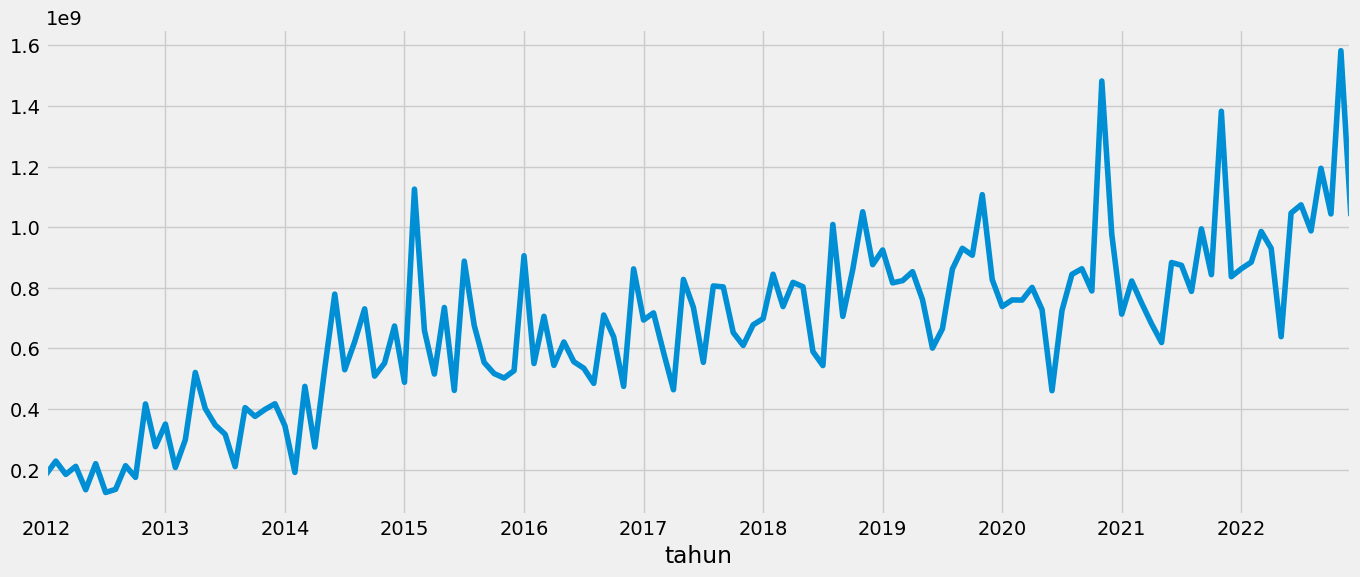

In [15]:
dts = pd.Series(data=df['jml_setor'].values, index=df['tahun'])
dts.plot(figsize=(15, 6))
plt.show()

# Mencari parameter terbaik ARIMA p, d, q

In [8]:
# Tentukan parameter p, d, dan q untuk mengambil nilai antara 0 sampai 5
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Hasilkan semua kombinasi berbeda dari triplet p, q, dan q musiman
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [16]:
warnings.filterwarnings("ignore")  # specify to ignore warning messages
best_result = [0, 0, 10000000]
p_params = [0, 1, 2, 3]
d_params = [0, 1, 2]
q_params = [0, 1, 2, 3]
P_params = [0, 1, 2, 3]
D_params = [0, 1, 2]
Q_params = [0, 1, 2, 3]
for p in p_params:
    for d in d_params:
        for q in q_params:
            for P in P_params:
                for D in D_params:
                    for Q in Q_params:
                        param = [p, d, q]
                        param_seasonal = [P, D, Q, 12]
                        try:
                            mod = sm.tsa.statespace.SARIMAX(dts, order=param, seasonal_order=param_seasonal)
                            results = mod.fit()
                            if results.aic < best_result[2]:
                                if results.aic > 300:
                                    best_result = [param, param_seasonal, results.aic]
                                    print('Best Result:', best_result)
                        except:
                            continue
print('\nBest Result:', best_result)

Best Result: [[0, 0, 0], [0, 0, 1, 12], 5715.519680955077]
Best Result: [[0, 0, 0], [0, 0, 3, 12], 5572.30387241025]
Best Result: [[0, 0, 0], [0, 1, 0, 12], 4940.114907112905]
Best Result: [[0, 0, 0], [0, 2, 1, 12], 4455.884834944649]
Best Result: [[0, 0, 0], [0, 2, 2, 12], 4442.637185664814]
Best Result: [[2, 2, 2], [0, 2, 2, 12], 4437.734177738676]
Best Result: [[2, 2, 3], [0, 2, 1, 12], 4429.765288788659]
Best Result: [[2, 2, 3], [0, 2, 2, 12], 4416.590113870928]

Best Result: [[2, 2, 3], [0, 2, 2, 12], 4416.590113870928]


In [7]:
 #order=(1, 0, 0),
  #                          seasonal_order=(0, 0, 0, 12),
  #                          enforce_stationarity=False,
    #                        enforce_invertibility=False)

# Plot model diagnostics

In [17]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
mod = sm.tsa.statespace.SARIMAX(dts,order=(2, 2, 3),seasonal_order=(0, 2, 2, 12),
                            enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  132
Model:             SARIMAX(2, 2, 3)x(0, 2, [1, 2], 12)   Log Likelihood               -1645.203
Date:                                 Sat, 01 Apr 2023   AIC                           3306.406
Time:                                         09:53:40   BIC                           3325.260
Sample:                                     01-01-2012   HQIC                          3313.953
                                          - 12-01-2022                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2565      0.330     -3.805      0.000      -1.904      -0

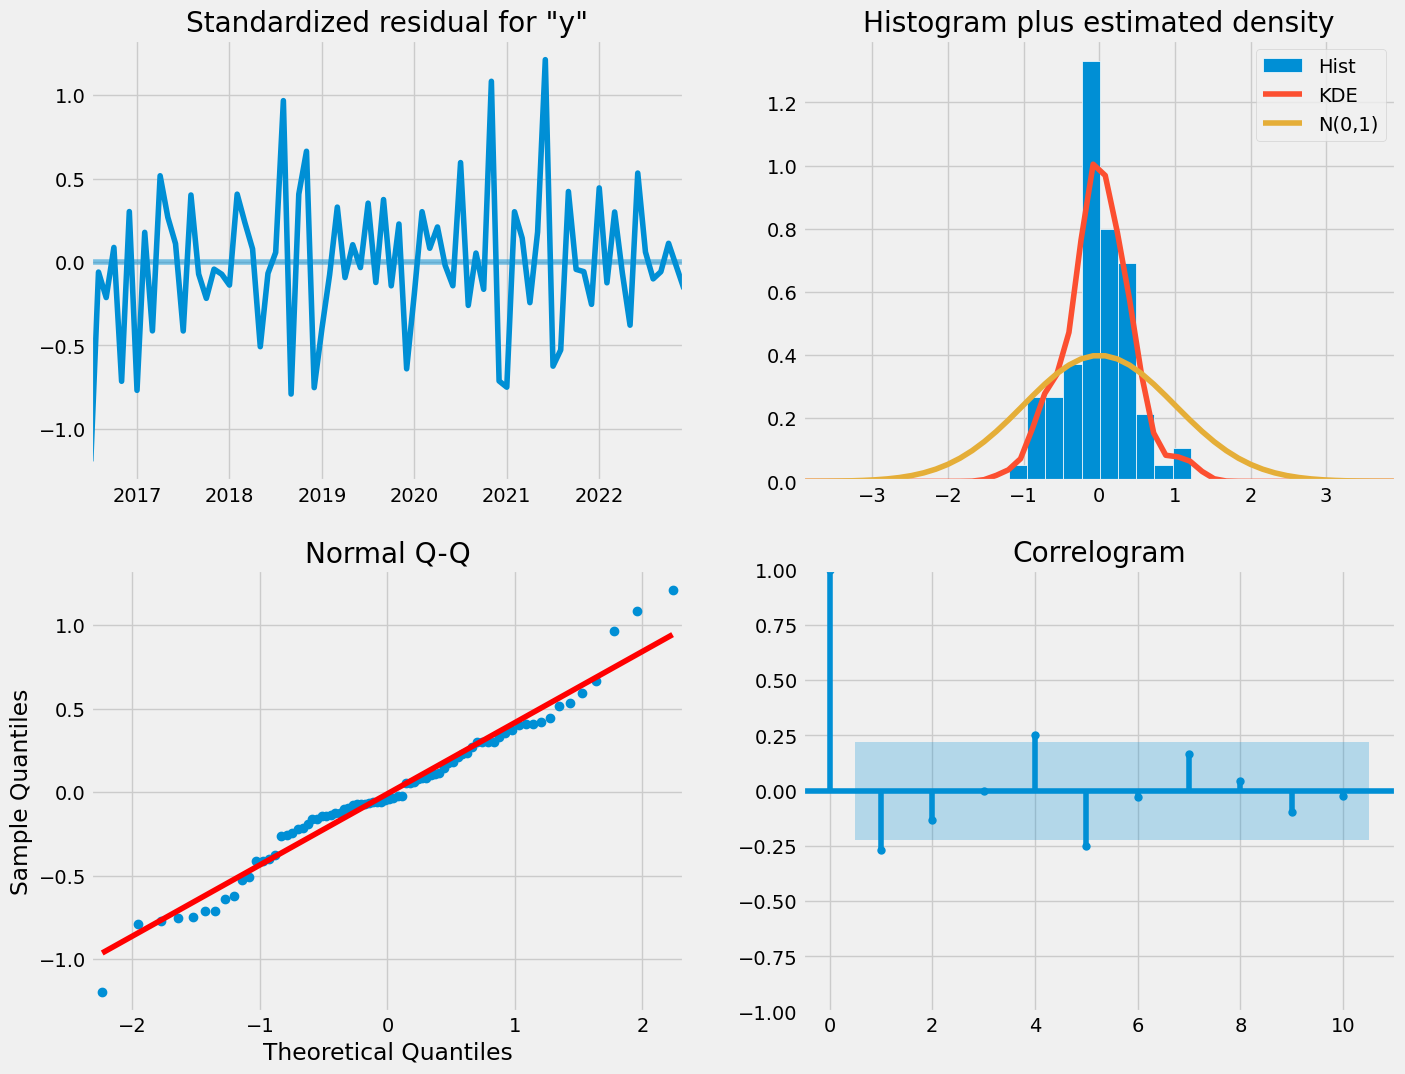

In [18]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

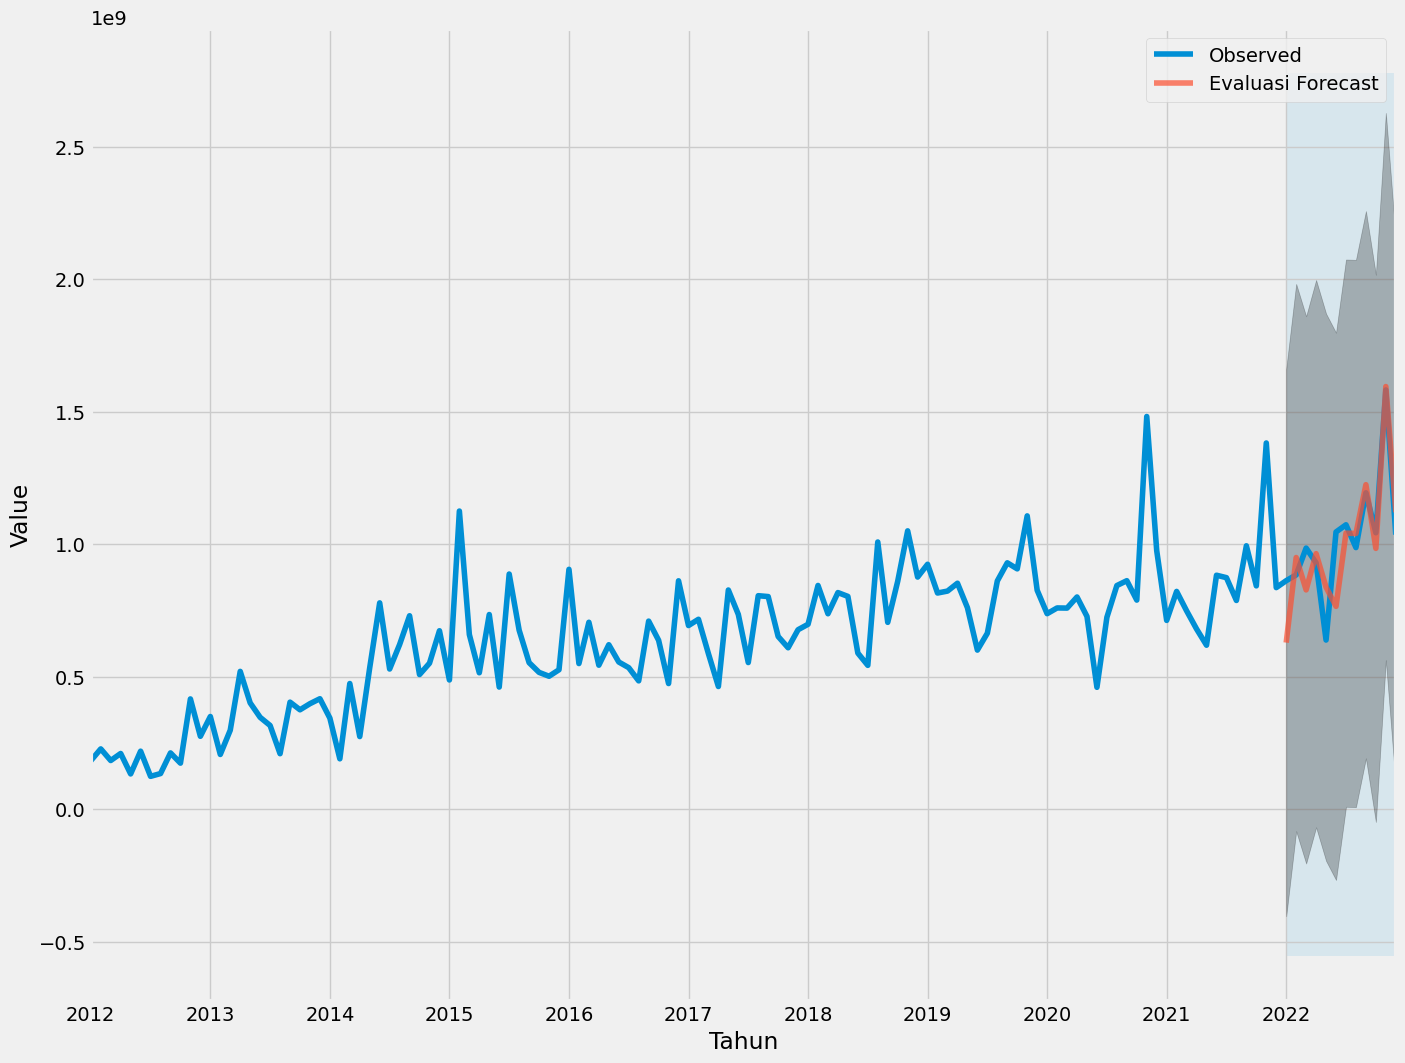

{"2022-01-01T00:00:00.000":628864868.4401780367,"2022-02-01T00:00:00.000":949993262.1571981907,"2022-03-01T00:00:00.000":827819726.9227728844,"2022-04-01T00:00:00.000":964613445.7190208435,"2022-05-01T00:00:00.000":837994171.4741039276,"2022-06-01T00:00:00.000":765761331.5850124359,"2022-07-01T00:00:00.000":1042012187.5391544104,"2022-08-01T00:00:00.000":1040810352.8954104185,"2022-09-01T00:00:00.000":1224912592.0299808979,"2022-10-01T00:00:00.000":984441264.3224591017,"2022-11-01T00:00:00.000":1595270247.3257837296,"2022-12-01T00:00:00.000":1121133266.7049489021}


In [20]:
pred = results.get_prediction(start=pd.to_datetime('2022-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = dts['2012':].plot(label='Observed', figsize=(15, 12))
pred.predicted_mean.plot(ax=ax, label='Evaluasi Forecast', alpha=.7)
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2022-01-01'), dts.index[-1],alpha=.1, zorder=-1)
ax.set_xlabel('Tahun')
ax.set_ylabel('Value')
plt.legend()
plt.show()

json_data = pred.predicted_mean.to_json(date_format='iso')
print(json_data)
with open('./datasets/hotel_predicted_ahead.json', 'w') as f:
    json.dump(json_data, f)

In [22]:
df_test = df[df.tahun.between('2022-01', '2022-12')]
dts_test = pd.Series(data=df_test['jml_setor'].values, index=df_test['tahun'])
y_test, pred_ahead = np.array(dts_test), np.array(pred.predicted_mean)
list_ape = []
for index, elem in np.ndenumerate(pred_ahead):
    ape = np.abs(elem-y_test[index]) / y_test[index]
    list_ape.append(ape*100)
mape = np.mean(list_ape)
print(list_ape)
print(mape)

[27.0965837653399, 7.420947477251835, 16.01782971394771, 3.719974350902582, 31.24450119680844, 26.821804860077147, 2.9371338491371555, 5.393863409717851, 2.568076948292446, 5.653574685237511, 0.8169521527069752, 8.17216053898539]
11.48861691236708


# Prediksi data selama 2 tahun

In [13]:
# prediksi 24 langkah ke depan di masa mendatang
pred_uc = results.get_forecast(steps=24, dynamic=False)
# Dapatkan interval
pred_ci = pred_uc.conf_int()


json_data = pred_uc.predicted_mean.to_json(date_format='iso')
print(json_data)
with open('./datasets/mblb_predicted.json', 'w') as f:
    json.dump(json_data, f) 

{"2022-01-01T00:00:00.000":698462779.6215524673,"2022-02-01T00:00:00.000":783329823.1099823713,"2022-03-01T00:00:00.000":750119091.8903326988,"2022-04-01T00:00:00.000":735319981.2762906551,"2022-05-01T00:00:00.000":669270563.1928772926,"2022-06-01T00:00:00.000":685681681.6198267937,"2022-07-01T00:00:00.000":804206978.6684527397,"2022-08-01T00:00:00.000":814152854.7298823595,"2022-09-01T00:00:00.000":932868287.7440558672,"2022-10-01T00:00:00.000":817985285.5591195822,"2022-11-01T00:00:00.000":1062540644.8649382591,"2022-12-01T00:00:00.000":901623031.3168200254,"2023-01-01T00:00:00.000":705106680.8667123318,"2023-02-01T00:00:00.000":801437323.9234720469,"2023-03-01T00:00:00.000":749590057.0628553629,"2023-04-01T00:00:00.000":709702984.834141016,"2023-05-01T00:00:00.000":645869206.4957329035,"2023-06-01T00:00:00.000":777800509.9756066799,"2023-07-01T00:00:00.000":836757035.5485758781,"2023-08-01T00:00:00.000":801941938.1582510471,"2023-09-01T00:00:00.000":961515788.2679817677,"2023-10-01T

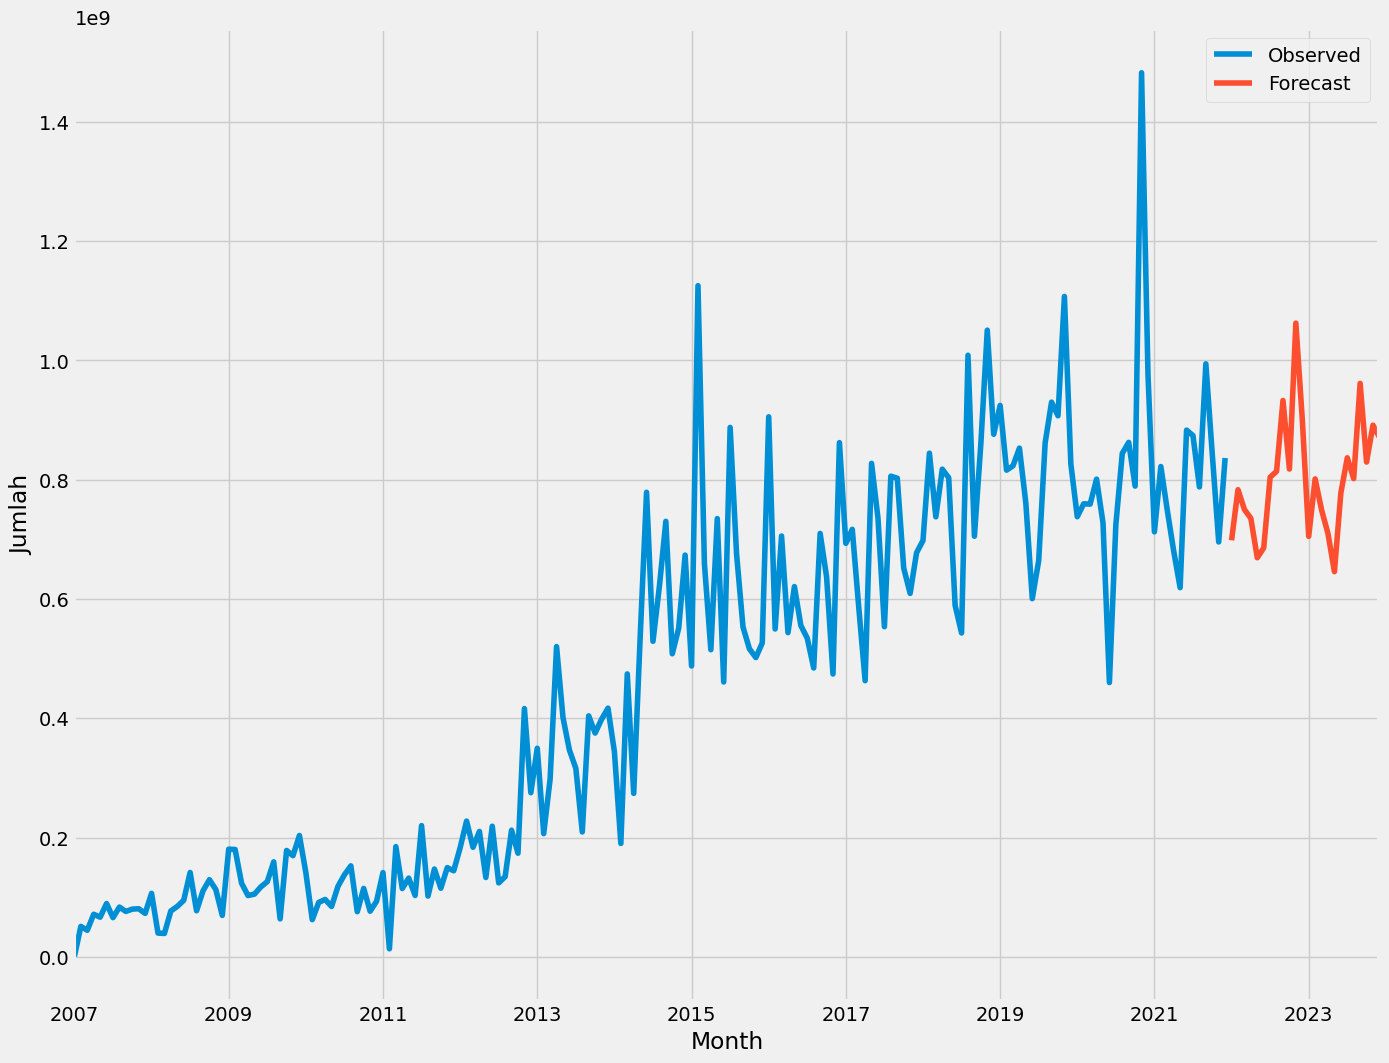

In [14]:
ax = dts.plot(label='Observed', figsize=(15, 12))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Month')
ax.set_ylabel('Jumlah')
plt.legend()
plt.show()